<h1><center>Amazon Product Recommendation Analysis</center></h>

This is the amazon product recommendation analysis for get know about 4 main problems that we fact and researching on. this is hope to improve the our bussiness strategies. we will main focus and analyzt on: 
<br>
<ol>
    <li>Product Recommendation Analysis</li>
    <li>Customer Satisfaction Analysis</li>
    <li>Customer Behaviours Analysis</li>
    <li>Customer Sentiment Analysis</li>
</ol>

<h3>1. Import Dependencies</h3>

In [1]:
import sklearn
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import re

#natural language toolkit, remove stopward from the text
import nltk
from nltk.corpus import stopwords

import string
#Sentiment Analysis 
from textblob import TextBlob
#word cloud
from wordcloud import WordCloud, STOPWORDS

<h3>2. Loan Dataset</h3>

In [2]:
#import dataset
amazon_df = pd.read_csv('dataset/amazon_dataset.csv')

In [3]:
pd.set_option('display.max_rows', 100)
amazon_df.head(2)

,Unnamed: 0,id,asin,name,helpful,text,rating,summary,unix_review_time,review_time
0,0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"


In [4]:
#drop a column
amazon_df.drop('Unnamed: 0', axis=1, inplace=True)

<h3>3. Data Cleansing | Wrangling</h3>

In [5]:
#check data types in each features
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   id                1000000 non-null  object
 1   asin              1000000 non-null  object
 2   name              989295 non-null   object
 3   helpful           1000000 non-null  object
 4   text              999361 non-null   object
 5   rating            1000000 non-null  int64 
 6   summary           999995 non-null   object
 7   unix_review_time  1000000 non-null  int64 
 8   review_time       1000000 non-null  object
dtypes: int64(2), object(7)
memory usage: 68.7+ MB


In [6]:
#rename all the features
amazon_df.rename(columns={
    'reviewerID':'id',
    'asin':'asin',
    'reviewerName':'name',
    'helpful':'helpful',
    'reviewText':'text',
    'overall':'rating',
    'summary':'summary',
    'unixReviewTime':'unix_review_time',
    'reviewTime':'review_time'
}, inplace=True)

In [7]:
#check sample and features number 
print("Samples | Features Number: ", amazon_df.shape)

Samples | Features Number:  (1000000, 9)


In [8]:
#check all datatypes
amazon_df.dtypes

id                  object
asin                object
name                object
helpful             object
text                object
rating               int64
summary             object
unix_review_time     int64
review_time         object
dtype: object

In [9]:
#revise the features
amazon_df.columns

Index(['id', 'asin', 'name', 'helpful', 'text', 'rating', 'summary',
       'unix_review_time', 'review_time'],
      dtype='object')

In [10]:
#check the duplicate values in each samples
amazon_duplication = amazon_df.duplicated(subset=['id','name','text','review_time'], keep='first')
if amazon_duplication.any() == True:
    print("Has Duplicated Values")
else:
    print("Dataset has no duplicated values")

Dataset has no duplicated values


In [11]:
#check null values
amazon_df.isnull().sum()

id                      0
asin                    0
name                10705
helpful                 0
text                  639
rating                  0
summary                 5
unix_review_time        0
review_time             0
dtype: int64

In [12]:
#drop nall values
amazon_df.dropna(axis=0, inplace=True)

In [13]:
#check null values
amazon_df.isnull().sum()

id                  0
asin                0
name                0
helpful             0
text                0
rating              0
summary             0
unix_review_time    0
review_time         0
dtype: int64

In [14]:
#Analyse the length of their comments whether customers are going to give lengthy or short one
def text_length_calculation(text):
    return len(text.split(' '))

In [15]:
amazon_df['text_length'] = amazon_df['text'].apply(text_length_calculation)
amazon_df['summary_length'] = amazon_df['summary'].apply(text_length_calculation)

In [16]:
#check new columns
amazon_df.head(3)

,id,asin,name,helpful,text,rating,summary,unix_review_time,review_time,text_length,summary_length
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013",156,3
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010",446,2
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010",888,2


In [17]:
# punctuations='-{}[];:"/,<>.?\|!@#$%^&*()+_=`~''
punctuations=string.punctuation
def remove_punctuation(review):
    no_punctuations=''
    for char in review:
        if char not in punctuations:
            no_punctuations=no_punctuations + char
    return no_punctuations

In [18]:
#apply remove_punctuation
amazon_df['text'] = amazon_df['text'].apply(remove_punctuation) 
amazon_df['summary'] = amazon_df['summary'].apply(remove_punctuation) 
amazon_df['name'] = amazon_df['name'].apply(remove_punctuation) 

In [19]:
#remove symbol function
#my own regular expression # NO WORK lol
def remove_symbol(text):
    text=text.replace('\*','',regex=True)
    text=text.replace('\&','',regex=True)
    text=text.replace('\#','',regex=True)
    text=text.replace('\$','',regex=True)
    text=text.replace('\!','',regex=True)
    text=text.replace('\;','',regex=True)
    text=text.replace('\.','',regex=True)
    text=text.replace('\@','',regex=True)
    text=text.replace('\%','',regex=True)
    text=text.replace('\^','',regex=True)
    text=text.replace('\<','',regex=True)
    text=text.replace('\>','',regex=True)
    text=text.replace('\~','',regex=True)
    text=text.replace('\+','',regex=True)
    text=text.replace('\-','',regex=True)
    text=text.replace('\}','',regex=True)
    text=text.replace('\{','',regex=True)
    text=text.replace('\[','',regex=True)
    text=text.replace('\]','',regex=True)

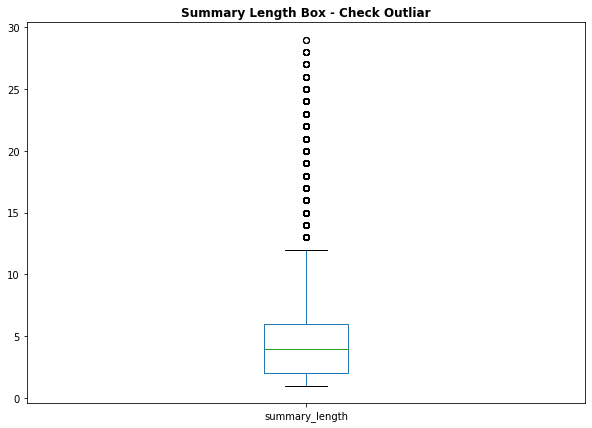

In [20]:
plt.figure(figsize=(10, 7))
amazon_df['summary_length'].plot.box()
plt.title("Summary Length Box - Check Outliar", fontweight='bold')
plt.show()

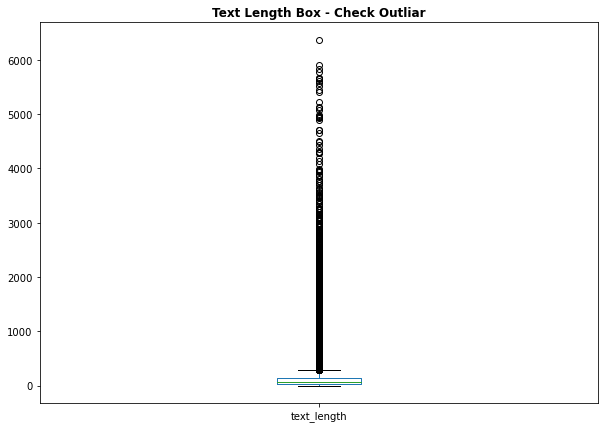

In [21]:
plt.figure(figsize=(10, 7))
amazon_df['text_length'].plot.box()
plt.title("Text Length Box - Check Outliar", fontweight='bold')
plt.show()

In [22]:
amazon_df.head(2)

,id,asin,name,helpful,text,rating,summary,unix_review_time,review_time,text_length,summary_length
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an OTR o...,5,Gotta have GPS,1370131200,"06 2, 2013",156,3
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]",Im a professional OTR truck driver and I bough...,1,Very Disappointed,1290643200,"11 25, 2010",446,2


In [23]:
amazon_df.shape

(988652, 11)

<h3>3. Data Analysis</h3>

<h3>3.1 Product Recommendation Analysis</h3>

Which users should recommend the product to?

In [24]:
#group by the dataset
recommendation_data = amazon_df.groupby('id').agg({
    'summary':'count', 
    'text':'count', 
    'asin':'count'
}).sort_values(by='text', ascending=False)

In [25]:
#create a pivot table 
recommendation_data.columns=['num_summary', 'numb_text', 'no_products_purchased']
recommendation_data.head(10)

,num_summary,numb_text,no_products_purchased
id,,,
A6FIAB28IS79,324,324,324
A5JLAU2ARJ0BO,315,315,315
A3OXHLG6DIBRW8,272,272,272
A680RUE1FDO8B,244,244,244
ADLVFFE4VBT8,223,223,223
A17BUUBOU0598B,173,173,173
A1ODOGXEYECQQ8,165,165,165
A231WM2Z2JL0U3,162,162,162
A250AXLRBVYKB4,159,159,159


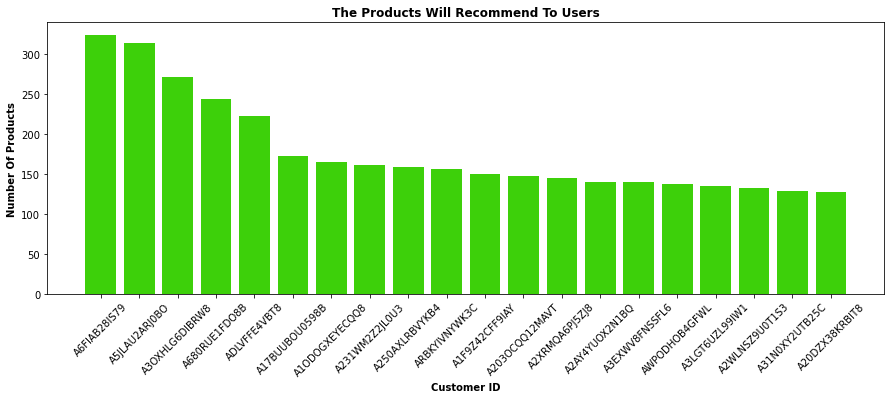

In [26]:
#draw a bar plot for products will recommend to users
top_users = recommendation_data.index[0:20]
top_products = recommendation_data['no_products_purchased'][0:20]
plt.figure(figsize=(15,5))
plt.bar(top_users, top_products, color='#3DD00A')
plt.ylabel("Number Of Products",fontweight='bold')
plt.xlabel("Customer ID",fontweight='bold')
plt.title("The Products Will Recommend To Users", fontweight='bold')
plt.xticks(rotation='45')
plt.show()

<h3>3.2 Customer Satisfaction Analysis</h3>

How many rating of product do customers really like?

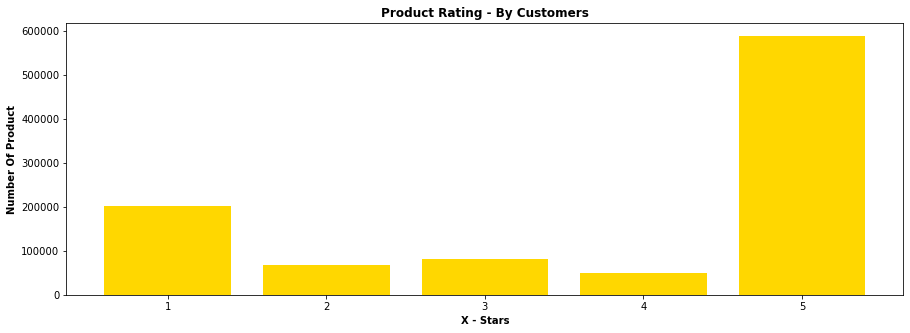

In [27]:
#product rating 
#draw a bar plot
plt.figure(figsize=(15,5))
plt.bar(amazon_df.rating.unique(),
        amazon_df.rating.value_counts(),color='gold')
plt.title("Product Rating - By Customers", fontweight='bold')
plt.ylabel("Number Of Product", fontweight='bold')
plt.xlabel("X - Stars", fontweight='bold')
plt.show()

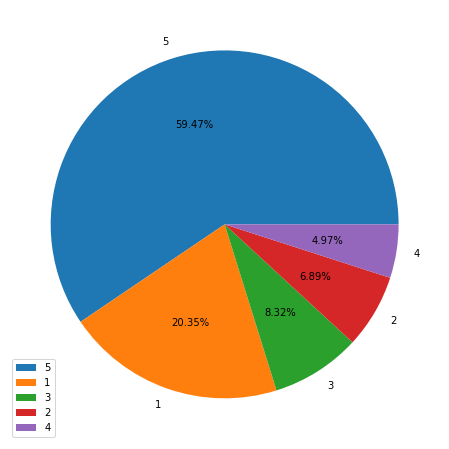

In [28]:
#pie
plt.figure(figsize=(15,8))
plt.pie(amazon_df.rating.value_counts(),
        labels=amazon_df.rating.unique(),
       autopct='%1.2f%%')
plt.legend()
plt.show()

<h3>3.3 Customer Behaviours Analysis</h3>

What is the behaviours of the user after using the product? 
<br>
This is will mainly fucos on text (Reviwer Text) of the dataset

In [29]:
#convert text to lower case
amazon_df['text'] = amazon_df['text'].str.lower()

In [30]:
#select data
data_text = amazon_df['text'][2]

In [31]:
#define the stopword
stopwords = set(STOPWORDS)
#download the stopword
#if no this code. stopwords wont be worked
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/VotanaSrey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
#Stopwords:  are the English words which does not add much meaning to a sentence. 
#They can safely be ignored without sacrificing the meaning of the sentence. 
#For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus.
#display list of words after removing stopwords
import nltk
from nltk.corpus import stopwords
#[word for word in data_text.split(' ') if word not in set(stopwords.words('english'))]

In [33]:
regular_ex = [word for word in data_text.split(' ') if word not in stopwords.words('english')]
str=''
for words in regular_ex:
    str = str + words
    str = str + ' '
str

'well say  ive unit truck four days  prior garmin 755t nontruck gps  one favorite features unit ability plan route determining mileage using stop via feature  would using map would route several different ways forcing unit putting stops vias different locations along route otherwise like gps determines thinks best route  could add 10 vias stop points route based mileage factors determine best route take  multiple stops ability route important reason garmin  however truck specific  considering hauling strictly hazmat wanted something would take consideration  perusing various forums review sites wordofmouth choices boiled garmin 465t rand mcnally intelliroute tnd 700  even though quite bit garmin chose tnd 700 several reasons  main one extra screen size ability coordinate rand mcnally truck atlas also ease updatingnow first impression tnd 700  seems aesthetically pleasing durably built unit  first thing noticed slow boot compared old garmin  whether unique tnd 700 common amongst truck s

In [34]:
#this is a function to remove stopwords
#********************************************************************************************************
cachedStopWords = stopwords.words("english")
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in cachedStopWords])
    return text

In [35]:
#remove the stop words from text features
#********************************************************************************************************
#it spends much time to remove stopword
#********************************************************************************************************
amazon_df.text = amazon_df.text.apply(remove_stopwords) 

In [36]:
#total word with stopwords
merge_words=' '.join(amazon_df['text'])

In [37]:
#wanna know text length? 
print(len(merge_words))

395410605


In [38]:
#limit text
merge_text = merge_words[10000:100000]
merge_text = re.sub(' +', ' ', merge_text)
merge_text = re.sub('[^a-zA-Z]',' ', merge_text)

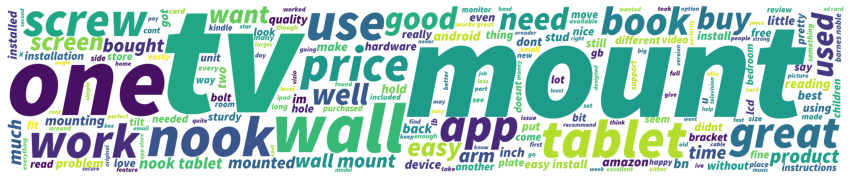

In [39]:
#word popularity to show buying behaviour
#********************************************************************************************************
#it spends much time to plot
#********************************************************************************************************
from nltk.corpus import stopwords

plt.figure(figsize=(15, 8))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=5000, height=1000, 
                      font_path='font.ttf',
                      stopwords=stopwords,
                      background_color='white').generate(merge_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<h3>3.4 Customer Sentiment Analysis</h3>

What is feeling do user express in a text?
<br>
- Happy or NOT
<br>
- Positive or Negative
<br>
- Great or NOT Great

<h3>3.4.1 Customer Sentiment Analysis - Polarity</h3>

Note:
- Positive if polarity > 0
- Negative if polarity < 0

In [40]:
#define data
data_summary_1 = amazon_df.summary[3]

In [41]:
#Find sentiment polarity of the array 0 summary
TextBlob(data_summary_1).sentiment.polarity

0.2

In [42]:
#Find polarity of the summary 
#Range -1 to 1
#Negative to Positive
#********************************************************************************************************
#it spends much time to work
#********************************************************************************************************
polarity=[]

for i in amazon_df['summary']:
    try:
        polarity.append(TextBlob(i).sentiment.polarity)
    except:
        polarity.append(0)
        
#check length
print(len(polarity))

988652


In [43]:
#add one feature
amazon_df['polarity'] = polarity

In [44]:
#define pos or neg
p_sentiment = amazon_df[amazon_df.polarity > 0]
n_sentiment = amazon_df[amazon_df.polarity < 0]

In [45]:
#converge all summary into one string
p_total_text=(' '.join(p_sentiment['summary']))
print(len(p_total_text))

15789027


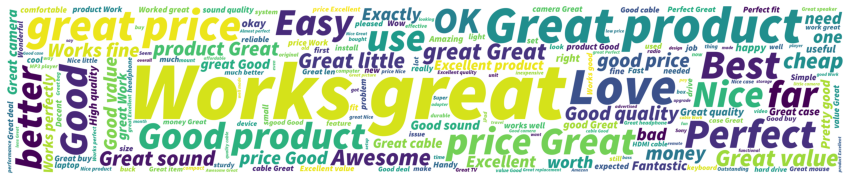

In [46]:
#positive sentiment
plt.figure(figsize=(15, 8))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=5000, height=1000, 
                      font_path='font.ttf',
                      stopwords=stopwords,
                      background_color='white').generate(p_total_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [47]:
#converge all summary into one string
n_total_text=(' '.join(n_sentiment['summary']))
print(len(n_total_text))

2479743


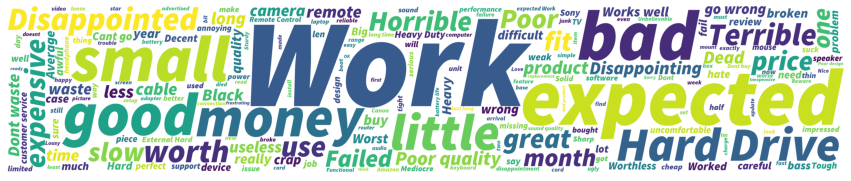

In [48]:
#negative sentiment
plt.figure(figsize=(15, 8))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=5000, height=1000, 
                      font_path='font.ttf',
                      stopwords=stopwords,
                      background_color='white').generate(n_total_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<h3>3.4.2 Customer Sentiment Analysis - Subjectivity </h3>

Note:
- Objective (Fact) = 0
- Subjective (Opinion) = 1

In [49]:
#define subjectivity
subjective = lambda x: TextBlob(x).sentiment.subjectivity
amazon_df['summary_sub'] = amazon_df['summary'].apply(subjective)

In [123]:
fact = amazon_df[amazon_df['summary_sub'] > 0]
opinion = amazon_df[amazon_df['summary_sub'] == 0 ]

In [125]:
#converge all summary into one string for fact subjectivity analysis
fact_total_text=(' '.join(fact['summary']))
print(len(fact_total_text))

19052922


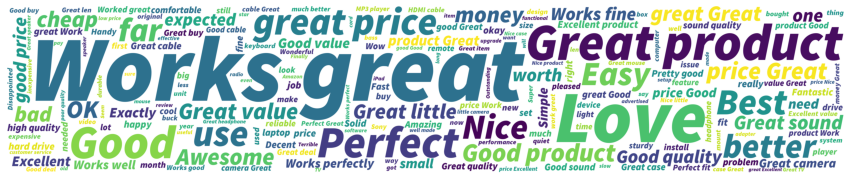

In [126]:
#subjectivity on sentiment analysis visualization - Fact
plt.figure(figsize=(15, 8))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=5000, height=1000, 
                      font_path='font.ttf',
                      stopwords=stopwords,
                      background_color='white').generate(fact_total_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [127]:
#converge all summary into one string for subjectivity analysis
opinion_total_text=(' '.join(opinion['summary']))
print(len(opinion_total_text))

6615473


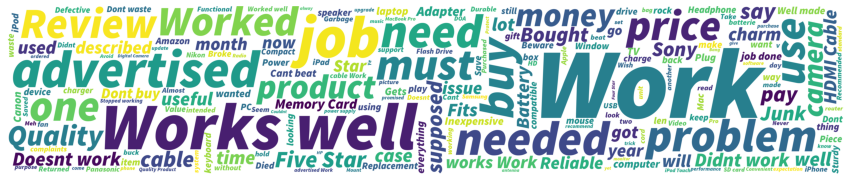

In [128]:
#subjectivity on sentiment analysis visualization - Opinion
plt.figure(figsize=(15, 8))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=5000, height=1000, 
                      font_path='font.ttf',
                      stopwords=stopwords,
                      background_color='white').generate(opinion_total_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()